In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from pandas import DataFrame, Series
from io import BytesIO
from bs4 import BeautifulSoup
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import platform
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

rfc = RandomForestRegressor()
xgb = XGBRegressor()
lr = LinearRegression()
lgbm = LGBMRegressor()
svc = LinearSVC()

In [2]:
y = pd.read_csv('./y_open_0905~_1000(5min)/y_open_0930.csv', index_col=0)
X = pd.read_csv('./X_Features.csv')


In [3]:

from datetime import datetime

# 시간 형태로 변경
X['date'] = pd.to_datetime(X['date'] ,format="%Y-%m-%d")
y['date'] = pd.to_datetime(y['date'],format= "%Y%m%d")

# merge X, y
df = pd.merge(X,y, on='date',how='inner')
df.sort_index(inplace=True)

# y의 시점 변환
df['open']=df['open'].shift(-1)

# index = date
df.set_index('date', inplace=True)
df.dropna(inplace=True)

# X, y 정의
y = df[['open']]
y.rename(columns={'open' : "target"})
X = df.drop(columns='open')

In [4]:
# 데이터셋을 다시 로드하고, 'date' 컬럼을 datetime으로 변환한 후 인덱스로 설정합니다.
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 연도별로 데이터프레임을 분리합니다.
years = df.index.year.unique()  # 연도별로 유니크한 값을 추출합니다.
yearly_dfs = {year: df[df.index.year == year] for year in years}  # 연도별 데이터프레임을 생성합니다.

# 2023년 데이터프레임을 예로 들어 확인해 봅니다.
yearly_dfs[2023].head(10)  # 2023년 데이터프레임의 처음 몇 행을 출력합니다.

,krx_close,krx_diff,krx_return,PER,PBR,Dividend_Yield,GOLD_RETURN,MEAL_RETURN,SP_500_RETURN,USD_KRW_RETURN,...,kodex_close,kodex_volume,kosdaq_open,kosdaq_high,kosdaq_low,kosdaq_close,kosdaq_volume,KODEX_return,Kosdaq150_return,open
date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,289.58,-0.21,-0.07,9.31,0.81,2.46,14.3,-10.50,-29,-18.0,...,28894,9429624,9562,9612,9397,9572,12479514,-162.0,-90.0,29046.0
2023-01-04,295.98,6.40,2.21,9.51,0.83,2.41,13.8,-35.00,12,-1.0,...,29503,8244362,9482,9646,9407,9632,11823207,167.0,0.0,29783.0
2023-01-05,297.87,1.89,0.64,9.57,0.83,2.39,-20.6,0.75,-31,5.0,...,29738,8290777,9632,9701,9497,9517,9131020,-206.0,-60.0,29699.0
2023-01-06,301.53,3.66,1.23,9.69,0.84,2.36,33.8,-5.00,72,18.0,...,30058,7506914,9457,9766,9452,9716,9713387,334.0,110.0,30578.0
2023-01-09,309.69,8.16,2.71,9.95,0.86,2.30,5.0,-6.50,-18,35.0,...,30868,8083754,9826,9935,9811,9895,9149776,-84.0,-44.0,30853.0
2023-01-10,309.57,-0.12,-0.04,9.95,0.86,2.30,0.8,-10.25,31,14.0,...,30907,7641179,9851,9915,9701,9701,6338292,138.0,100.0,30991.0
2023-01-11,310.38,0.81,0.26,9.98,0.87,2.30,-2.4,9.75,37,-3.0,...,30961,6137182,9801,9985,9801,9930,8160934,187.0,85.0,30956.0
2023-01-12,310.70,0.32,0.10,9.99,0.87,2.29,19.1,3.75,6,2.0,...,31050,5541541,10015,10025,9881,9975,7228509,78.0,0.0,31275.0
2023-01-13,313.77,3.07,0.99,10.09,0.88,2.27,22.9,0.25,39,5.0,...,31275,6372053,9975,10045,9876,9925,6856334,59.0,-10.0,31433.0


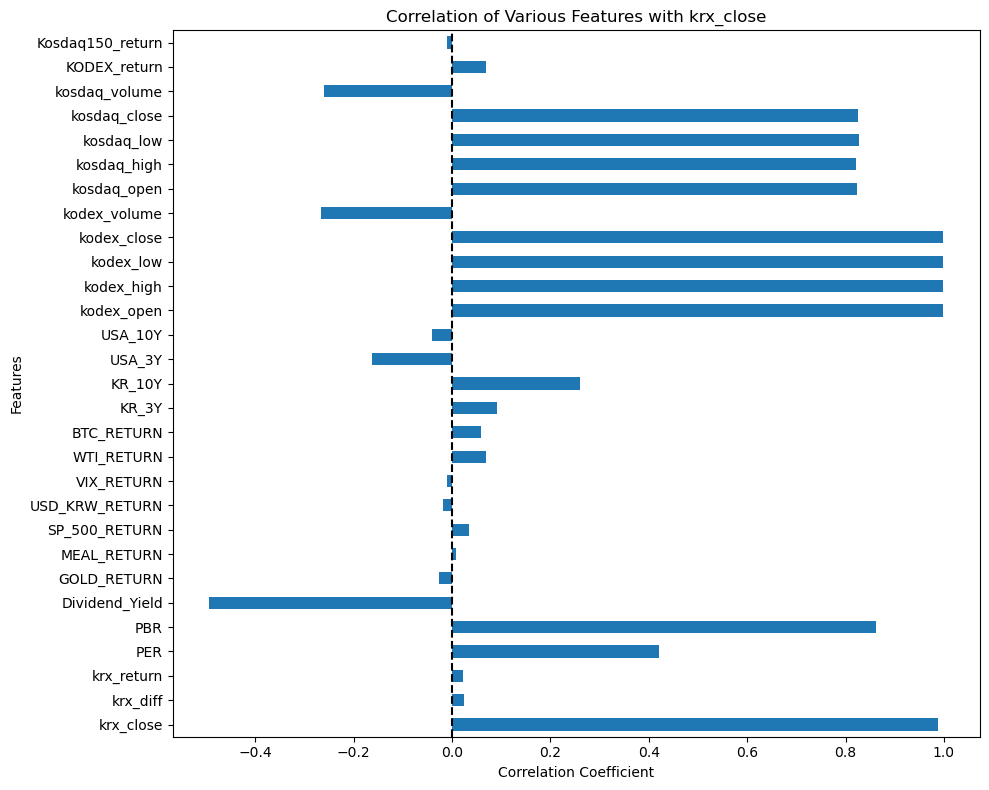

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Extract the 'krx_close' column's correlation values
krx_close_correlations = correlation_matrix['open'].drop('open')  # drop self-correlation

# Plot a horizontal bar chart for the 'krx_close' correlations
plt.figure(figsize=(10, 8))
krx_close_correlations.plot(kind='barh')  # Change to horizontal bar chart
plt.title('Correlation of Various Features with krx_close')
plt.ylabel('Features')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='k', linestyle='--')  # Add a vertical line at zero
plt.tight_layout()  # Adjust the layout

# Show the plot
plt.show()

In [86]:
# 모델을 통한 피처셀렉
def feature_select(X, y, min_features = 10, step = 1, cv = 5) :
    model = RandomForestRegressor(random_state=17, n_estimators=100)
    selector = RFECV(model, step=step, cv=cv, min_features_to_select=min_features)
    selector = selector.fit(X, y)
    selected_features = X.columns[selector.support_]
    return selected_features

selected_features = feature_select(X, y, cv = 5)

c:\Users\hotte\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\hotte\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\hotte\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\hotte\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConvers

In [44]:
selected_features

Index(['BTC_RETURN', 'KR_3Y', 'KR_10Y', 'kodex_open', 'kodex_high',
       'kodex_low', 'kodex_close', 'kosdaq_open', 'kosdaq_high', 'kosdaq_low'],
      dtype='object')

In [87]:
X = X[['BTC_RETURN', 'KR_3Y', 'KR_10Y', 'kodex_open', 'kodex_high','kodex_low', 'kodex_close', 'kosdaq_open', 'kosdaq_high', 'kosdaq_low']]

In [88]:
X_train, y_train, X_test, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

In [89]:
X_test

,open
date,
2023-10-25,31355.0
2023-10-24,32095.0
2023-10-23,31810.0
2023-10-20,31845.0
2023-10-19,31980.0
...,...
2019-10-15,25569.0
2019-10-14,25326.0
2019-10-11,25362.0


In [73]:
def rf_model(X_train, y_train, X_test, y_test, cv=5) :

    # 최적의 하이퍼 파라미터 찾기
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # rf 초기화
    rf = RandomForestRegressor(random_state=42)

    # Grid search
    grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, X_test)

    # 최적값을 모델에 적용
    best_params = grid_search.best_params_
    optimized_rf = RandomForestRegressor(**best_params, random_state=42)

    # Train the model using the training data
    optimized_rf.fit(X_train, X_test)

    # Predict on the test set
    y_pred_rf = optimized_rf.predict(y_train)

    # Calculate r2_score
    rf_r2_score = r2_score(y_test, y_pred_rf)

    y_pred_rf = pd.DataFrame(y_pred_rf, index=y_test.index, columns=['signal'])
    print(best_params, rf_r2_score)
    return y_pred_rf

In [74]:
rf_model(X_train, y_train, X_test, y_test, cv=5)

c:\Users\hotte\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\hotte\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} 0.9855005518207713


,signal
date,
2019-10-07,24662.879833
2019-10-04,24571.818167
2019-10-02,24962.180000
2019-10-01,25244.204905
2019-09-30,25036.818333
...,...
2018-10-08,26208.727966
2018-10-05,26351.490816
2018-10-04,26696.164000


In [ ]:
y

In [57]:
def xgb_model(X_train, y_train, X_test, y_test, cv=5) :

    # 최적의 하이퍼 파라미터 찾기
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.5],
        'n_estimators': [50, 100, 150, 300,],
        'max_depth': [3, 5, 7],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
    }


    # xgb 초기화
    xgb = XGBRegressor(random_state=42)

    # Grid search
    grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, X_test)

    # 최적값을 모델에 적용
    best_params = grid_search.best_params_
    optimized_rf = XGBRegressor(**best_params, random_state=42)

    # Train the model using the training data
    optimized_rf.fit(X_train, X_test)

    # Predict on the test set
    y_pred_rf = optimized_rf.predict(y_train)

    # Calculate r2_score
    xgb_r2_score = r2_score(y_test, y_pred_rf)

    y_pred_rf = pd.DataFrame(y_pred_rf, index=y_test.index, columns=['signal'])
    print(best_params, xgb_r2_score)
    return y_pred_rf

ValueError: Found input variables with inconsistent numbers of samples: [960, 240]